In [1]:
import os
import time

#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import h5py
import numpy as np
import pandas as pd
import tensorflow as tf

import baskerville
from baskerville import seqnn
from baskerville import gene as bgene
from baskerville import dna

import json

import pysam

import pyfaidx

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from borzoi_helpers import *


2023-08-17 13:58:01.371932: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-17 13:58:02.260991: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-17 13:58:02.261087: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-17 13:58:02.261096: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [ ]:
#Download model files and other dependencies (skip this cell if already executed once)

#Create model file structure
!mkdir saved_models
!mkdir saved_models/f0
!mkdir saved_models/f1
!mkdir saved_models/f2
!mkdir saved_models/f3

#Download model weights
!wget https://storage.googleapis.com/seqnn-share/borzoi/f0/model0_best.h5 -O saved_models/f0/model0_best.h5
!wget https://storage.googleapis.com/seqnn-share/borzoi/f1/model0_best.h5 -O saved_models/f1/model0_best.h5
!wget https://storage.googleapis.com/seqnn-share/borzoi/f2/model0_best.h5 -O saved_models/f2/model0_best.h5
!wget https://storage.googleapis.com/seqnn-share/borzoi/f3/model0_best.h5 -O saved_models/f3/model0_best.h5

#Download and uncompress annotation files
!wget -O - https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_nort.gtf.gz | gunzip -c > gencode41_basic_nort.gtf
!wget https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_protein_splice.csv.gz
!wget https://storage.googleapis.com/seqnn-share/helper/polyadb_human_v3.csv.gz

#Download and index hg38 genome
!wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > hg38.fa
pyfaidx.Faidx('hg38.fa')


In [ ]:
#Model configuration

params_file = 'params_pred.json'
targets_file = 'targets_gtex.txt' #Subset of targets_human.txt

seq_len = 524288
n_folds = 4       #To use only one model fold, change to 'n_folds = 1'
rc = True         #Average across reverse-complement prediction

#Read model parameters

with open(params_file) as params_open :
    
    params = json.load(params_open)
    
    params_model = params['model']
    params_train = params['train']

#Read targets

targets_df = pd.read_csv(targets_file, index_col=0, sep='\t')
target_index = targets_df.index

#Create local index of strand_pair (relative to sliced targets)
if rc :
    strand_pair = targets_df.strand_pair
    
    target_slice_dict = {ix : i for i, ix in enumerate(target_index.values.tolist())}
    slice_pair = np.array([
        target_slice_dict[ix] if ix in target_slice_dict else ix for ix in strand_pair.values.tolist()
    ], dtype='int32')

#Initialize model ensemble

models = []
for fold_ix in range(n_folds) :
    
    model_file = "saved_models/f" + str(fold_ix) + "/model0_best.h5"

    seqnn_model = seqnn.SeqNN(params_model)
    seqnn_model.restore(model_file, 0)
    seqnn_model.build_slice(target_index)
    if rc :
        seqnn_model.strand_pair.append(slice_pair)
    seqnn_model.build_ensemble(rc, '0')
    
    models.append(seqnn_model)


In [4]:
#Initialize fasta sequence extractor

fasta_open = pysam.Fastafile('hg38.fa')

#Load APA atlas

apa_df = pd.read_csv('polyadb_human_v3.csv.gz', sep='\t', compression='gzip')
apa_df = apa_df[['pas_id', 'gene', 'chrom', 'position_hg38', 'strand', 'site_num', 'num_sites', 'site_type', 'pas_type', 'total_count']]

apa_df.loc[apa_df['pas_type'] == 'NoPAS', 'pas_type'] = 'No_CSE'

#Only consider 3' UTR sites
apa_df = apa_df.query("site_type == '3\\' most exon'").copy().reset_index(drop=True)

print("len(apa_df) = " + str(len(apa_df)))


len(apa_df) = 114605


In [5]:
#Print index of GTEx muscle and heart tracks in targets file

targets_df['local_index'] = np.arange(len(targets_df))

print("muscle tracks = " + str(targets_df.loc[targets_df['description'] == 'RNA:muscle']['local_index'].tolist()))
print("heart tracks = " + str(targets_df.loc[targets_df['description'] == 'RNA:heart']['local_index'].tolist()))


muscle tracks = [47, 48, 49]
heart tracks = [35, 36, 37]


2023-08-17 13:48:41.655589: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-08-17 13:48:42.073145: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


-- Counts --
 - max_y_wt = 561096.56
 - max_y_mut = 642148.25
 -- (max_y = 642148.25)


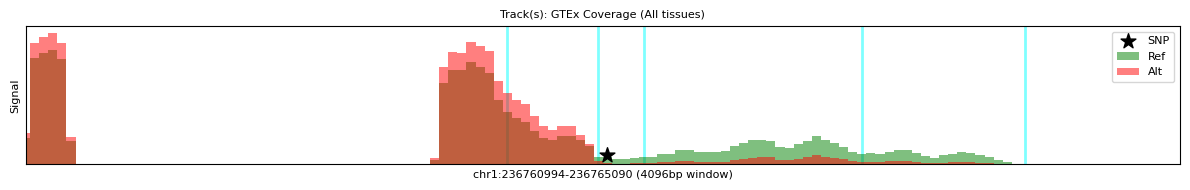

 - max_y_wt = 12134187.0
 - max_y_mut = 13846305.0
 -- (max_y = 13846305.0)


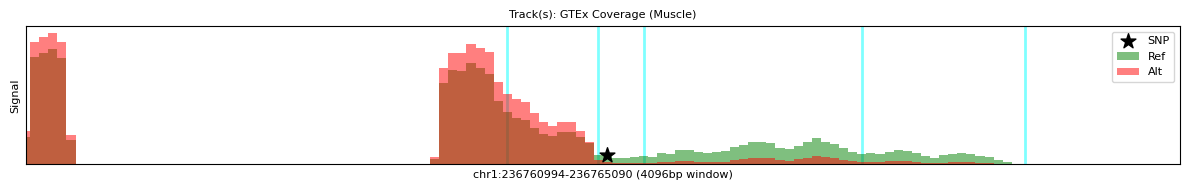

 - max_y_wt = 4499694.0
 - max_y_mut = 5190822.0
 -- (max_y = 5190822.0)


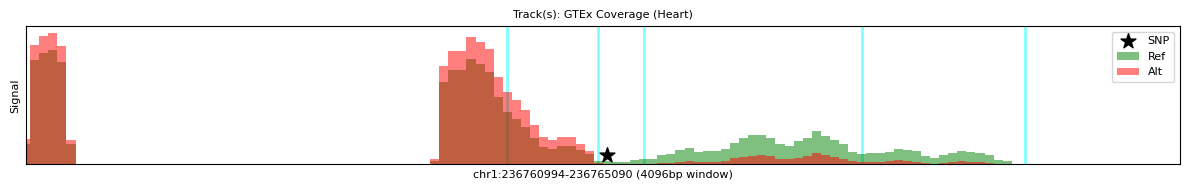

In [6]:
#Predict for chr1_236763042_A_G

save_figs = False
save_suffix = '_chr1_236763042_A_G'

center_pos = 236763042

chrom = 'chr1'
poses = [236763042]
alts = ['G']

start = center_pos - seq_len // 2
end = center_pos + seq_len // 2

sequence_one_hot_wt = process_sequence(fasta_open, chrom, start, end)

#Induce mutation(s)
sequence_one_hot_mut = np.copy(sequence_one_hot_wt)

for pos, alt in zip(poses, alts) :
    alt_ix = -1
    if alt == 'A' :
        alt_ix = 0
    elif alt == 'C' :
        alt_ix = 1
    elif alt == 'G' :
        alt_ix = 2
    elif alt == 'T' :
        alt_ix = 3

    sequence_one_hot_mut[pos-start-1] = 0.
    sequence_one_hot_mut[pos-start-1, alt_ix] = 1.

#Make predictions
y_wt = predict_tracks(models, sequence_one_hot_wt)
y_mut = predict_tracks(models, sequence_one_hot_mut)

#Visualize quantized tracks over SNP

plot_window = 4096
bin_size = 32
pad = 16

rescale_tracks = True
normalize_counts = False

anno_df = apa_df

#Tracks
track_indices = [
    np.arange(0, 89).tolist(),
    [47, 48, 49],
    [35, 36, 37],
]

track_names = [
    'GTEx Coverage (All tissues)',
    'GTEx Coverage (Muscle)',
    'GTEx Coverage (Heart)',
]

track_scales = [
    0.01,
    0.01,
    0.01,
]

track_transforms = [
    3./4.,
    3./4.,
    3./4.,
]

soft_clips = [
    384.,
    384.,
    384.,
]

print("-- Counts --")
plot_coverage_track_pair_bins(y_wt, y_mut, chrom, start, center_pos, poses, track_indices, track_names, track_scales, track_transforms, soft_clips, plot_window=plot_window, normalize_window=8*plot_window, bin_size=bin_size, pad=pad, rescale_tracks=rescale_tracks, normalize_counts=normalize_counts, save_figs=save_figs, save_suffix=save_suffix, anno_df=anno_df)


In [7]:
#Print polyA site bin positions and other info

plot_start = center_pos - plot_window // 2
plot_end = center_pos + plot_window // 2

plot_start_bin = (plot_start - start) // bin_size - pad
plot_end_bin = (plot_end - start) // bin_size - pad

mut_bin = (poses[0] - start) // bin_size - pad

#Get polyA site positions
pas_poses = apa_df.query("chrom == '" + chrom + "' and position_hg38 >= " + str(plot_start) + " and position_hg38 < " + str(plot_end))['position_hg38'].values.tolist()

print("mut_bin = " + str(mut_bin))
print("")

#Print polyA site positions
for pas_ix, pas_pos in enumerate(pas_poses) :
    
    pas_bin = int((pas_pos - start) // 32) - 16
    
    bin_end = pas_bin + 3
    bin_start = bin_end - 5
    
    print("pas_ix = " + str(pas_ix) + ": bin = " + str(pas_bin) + " (" + str(bin_start) + " - " + str(bin_end) + ")")


mut_bin = 8176

pas_ix = 0: bin = 8165 (8163 - 8168)
pas_ix = 1: bin = 8175 (8173 - 8178)
pas_ix = 2: bin = 8180 (8178 - 8183)
pas_ix = 3: bin = 8204 (8202 - 8207)
pas_ix = 4: bin = 8222 (8220 - 8225)


In [7]:
#Choose polyA sites to use for attributions

prox_pas_pos = pas_poses[1]

prox_pas_bin = 8175
dist_pas_bin = 8222


In [ ]:
#Get contribution scores (gradient) for pooled GTEX tracks

_, _, [pred_grad_wt, pred_grad_mut] = get_prediction_gradient_w_rc(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    dist_pas_bin-5,
    dist_pas_bin,
    prox_pas_bin-5,
    prox_pas_bin,
    target_index[np.arange(0, 89).tolist()].tolist(),
    0.01,
    3./4.,
    clip_soft=384.,
    use_mean=False,
    use_ratio=True,
    use_logodds=False,
    subtract_avg=True,
    fold_index=[0, 1, 2, 3],
)


--- WT ---


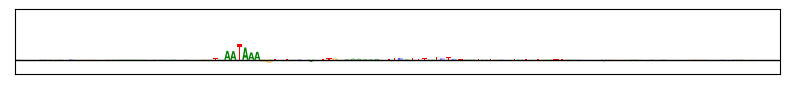

--- Mut ---


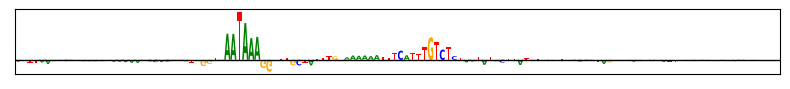

In [18]:
#Visualize contribution scores

visualize_input_gradient_pair(
    pred_grad_wt,
    pred_grad_mut,
    plot_start=(prox_pas_pos - start) + 3 - 64,
    plot_end=(prox_pas_pos - start) + 3 + 64,
    save_figs=True,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_grad_gtex_snp_4_folds_gtex_cov_undo_clip'
)


In [ ]:
#Get contribution scores (noisy gradient) for pooled GTEX tracks

_, _, [pred_grad_wt, pred_grad_mut] = get_prediction_gradient_noisy_w_rc(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    dist_pas_bin-5,
    dist_pas_bin,
    prox_pas_bin-5,
    prox_pas_bin,
    target_index[np.arange(0, 89).tolist()].tolist(),
    0.01,
    3./4.,
    clip_soft=384.,
    use_mean=False,
    use_ratio=True,
    use_logodds=False,
    subtract_avg=True,
    fold_index=[0, 1, 2, 3],
    n_samples=10,
    sample_prob=0.925
)


--- WT ---


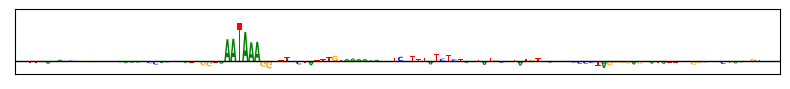

--- Mut ---


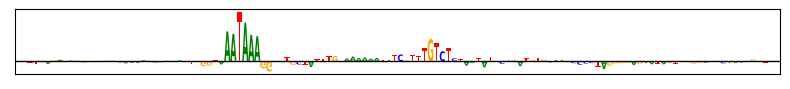

In [26]:
#Visualize contribution scores

visualize_input_gradient_pair(
    pred_grad_wt,
    pred_grad_mut,
    plot_start=(prox_pas_pos - start) + 3 - 64,
    plot_end=(prox_pas_pos - start) + 3 + 64,
    save_figs=True,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_noisygrad_gtex_snp_4_folds_gtex_cov_undo_clip'
)


In [ ]:
#Get contribution scores (ISM) for pooled GTEX tracks

[pred_ism_wt, pred_ism_mut] = get_ism(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    (prox_pas_pos - start) + 3 - 64,
    (prox_pas_pos - start) + 3 + 64,
    dist_pas_bin-5,
    dist_pas_bin,
    prox_pas_bin-5,
    prox_pas_bin,
    np.arange(0, 89).tolist(),
    0.01,
    3./4.,
    384.,
    use_mean=False,
    use_ratio=True,
    use_logodds=False
)


--- WT ---


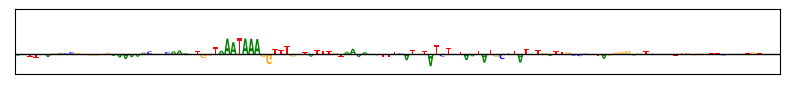

--- Mut ---


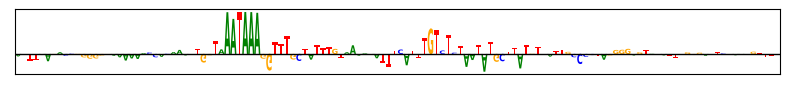

In [14]:
#Visualize contribution scores

visualize_input_gradient_pair(
    pred_ism_wt,
    pred_ism_mut,
    plot_start=(prox_pas_pos - start) + 3 - 64,
    plot_end=(prox_pas_pos - start) + 3 + 64,
    save_figs=True,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_gtex_snp_4_folds_gtex_cov_undo_clip'
)


In [ ]:
#Get contribution scores (ISM shuffle) for pooled GTEX tracks

[pred_ism_wt, pred_ism_mut] = get_ism_shuffle(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    (prox_pas_pos - start) + 3 - 64,
    (prox_pas_pos - start) + 3 + 64,
    dist_pas_bin-5,
    dist_pas_bin,
    prox_pas_bin-5,
    prox_pas_bin,
    np.arange(0, 89).tolist(),
    0.01,
    3./4.,
    384.,
    window_size=5,
    n_samples=24,
    use_mean=False,
    use_ratio=True,
    use_logodds=False
)


--- WT ---


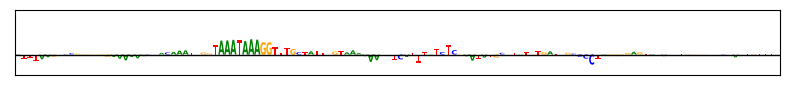

--- Mut ---


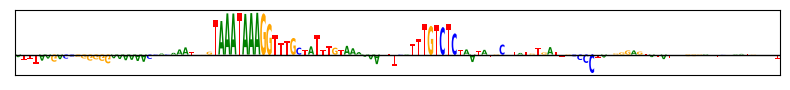

In [22]:
#Visualize contribution scores

visualize_input_gradient_pair(
    pred_ism_wt,
    pred_ism_mut,
    plot_start=(prox_pas_pos - start) + 3 - 64,
    plot_end=(prox_pas_pos - start) + 3 + 64,
    save_figs=True,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_shuffle_gtex_snp_4_folds_gtex_cov_undo_clip'
)


In [8]:
#Load samples with reference- and alternate alleles respectively

#These files are protected by dbGaP - email to request access

cov_files_wt = pd.read_csv("gtex_ref_chr1_236763042_A_G.txt", sep='\t', names=['file'])['file'].values.tolist()
cov_files_mut = pd.read_csv("gtex_alt_chr1_236763042_A_G.txt", sep='\t', names=['file'])['file'].values.tolist()


gtex_targets_wt.shape = (16352, 6)
gtex_targets_mut.shape = (16352, 6)
 - max_y_wt = 110282.92
 - max_y_mut = 108429.734
 -- (max_y = 110282.92)


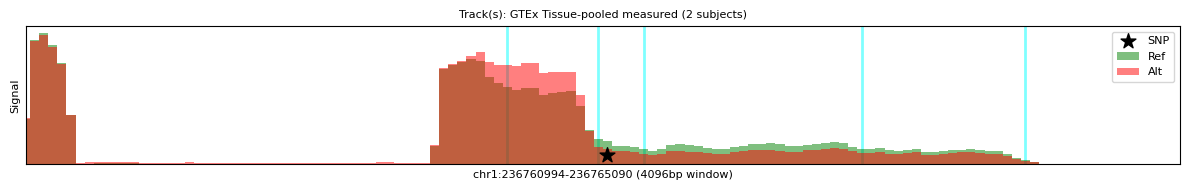

 - max_y_wt = 97425.34
 - max_y_mut = 96755.266
 -- (max_y = 97425.34)


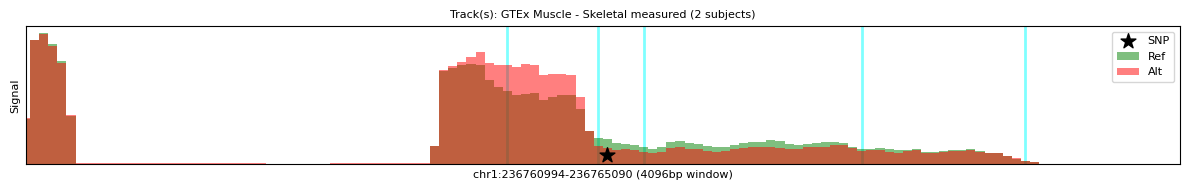

 - max_y_wt = 96052.87
 - max_y_mut = 95051.46
 -- (max_y = 96052.87)


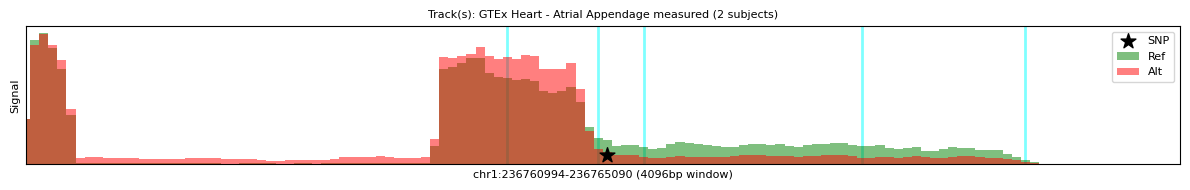

 - max_y_wt = 137370.53
 - max_y_mut = 138814.69
 -- (max_y = 138814.69)


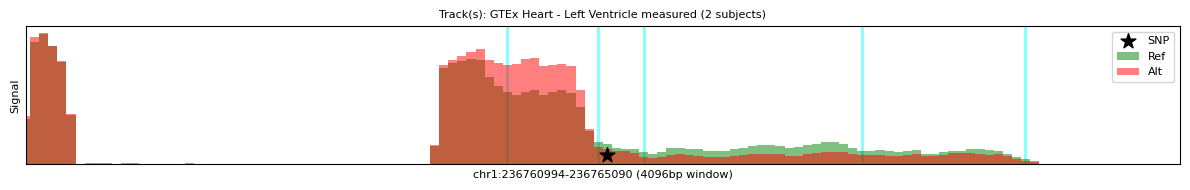

In [9]:
#Read measured coverage tracks for chr1_236763042_A_G

save_figs = False
save_suffix = '_chr1_236763042_A_G_meas_2_subjects'

center_pos = 236763042

chrom = 'chr1'
poses = [236763042]
alts = ['G']

start = center_pos - seq_len // 2
end = center_pos + seq_len // 2

blacklist_bed = "/home/drk/common/data/genomes/hg38/blacklist/blacklist_hg38_all.bed"

read_coverage_func_wt, close_coverage_func_wt = get_coverage_reader(cov_files_wt, 16384, 16, blacklist_bed)
read_coverage_func_mut, close_coverage_func_mut = get_coverage_reader(cov_files_mut, 16384, 16, blacklist_bed)

gtex_targets_wt = read_coverage_func_wt(chrom, start, end, clip_soft=384., clip=768., scale=0.01)
gtex_targets_mut = read_coverage_func_mut(chrom, start, end, clip_soft=384., clip=768., scale=0.01)

close_coverage_func_wt()
close_coverage_func_mut()

print("gtex_targets_wt.shape = " + str(gtex_targets_wt.shape))
print("gtex_targets_mut.shape = " + str(gtex_targets_mut.shape))

plot_window = 4096
bin_size = 32
pad = 16

anno_df = apa_df

rescale_tracks = True
normalize_counts = True

#Tracks
track_indices = [
    np.arange(6).tolist(),
    [0, 1],
    [2, 3],
    [4, 5],
]

track_names = [
    'GTEx Tissue-pooled measured (2 subjects)',
    'GTEx Muscle - Skeletal measured (2 subjects)',
    'GTEx Heart - Atrial Appendage measured (2 subjects)',
    'GTEx Heart - Left Ventricle measured (2 subjects)',
]

track_scales = [
    0.01,
    0.01,
    0.01,
    0.01,
]

track_transforms = [
    3./4.,
    3./4.,
    3./4.,
    3./4.,
]

soft_clips = [
    384.,
    384.,
    384.,
    384.,
]

plot_coverage_track_pair_bins(gtex_targets_wt[None, None, ...], gtex_targets_mut[None, None, ...], chrom, start, center_pos, poses, track_indices, track_names, track_scales, track_transforms, soft_clips, plot_window=plot_window, normalize_window=8*plot_window, bin_size=bin_size, pad=pad, rescale_tracks=rescale_tracks, normalize_counts=normalize_counts, save_figs=save_figs, save_suffix=save_suffix, anno_df=anno_df)
